### Modeling Fakeddit
* [Paper](https://arxiv.org/pdf/1911.03854.pdf)

### Setup Environment:

In [1]:
import os
import pandas as pd

from src.classifiers import preprocess_data, process_labels,split_data

from src.classifiers import VQADataset
from torch.utils.data import DataLoader

from src.classifiers_cpu_metrics import train_early_fusion, train_late_fusion

In [2]:
PATH = 'Embeddings_vlm/fakeddit/'
FILE = 'embeddings_blip2.csv'

FILE_PATH = os.path.join(PATH, FILE)

## Get data

In [3]:
df = pd.read_csv(FILE_PATH)
df.drop(columns=['hasImage', 'image_url'], inplace=True)
df.head()

,author,clean_title,created_utc,domain,id,linked_submission_id,num_comments,score,subreddit,title,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
0,michaelconfoy,loose talk got there first keep it under your ...,1.429942e+09,i.imgur.com,./datasets/fakeddit/images/33snxf.jpg,NaN,6.0,70,propagandaposters,"""Loose talk got there first! Keep it under you...",...,-0.020604,-0.375106,0.544828,0.099819,0.486417,-0.444748,-0.177809,-1.414067,-0.039285,0.207224
1,SaltMineForeman,this tree at my campsite naturally grew a hear...,1.554421e+09,i.imgur.com,./datasets/fakeddit/images/b9k2ta.jpg,NaN,2.0,30,mildlyinteresting,This tree at my campsite naturally grew a hear...,...,0.062831,-0.307634,0.690449,-0.156866,0.570354,-0.645805,-0.075894,-1.452406,-0.235834,-0.173463
2,Shawn_666,fdr addressing the nation,1.522982e+09,i.redd.it,./datasets/fakeddit/images/8a5wy9.jpg,NaN,1.0,12,fakehistoryporn,FDR addressing the nation (1932),...,0.151737,-0.497216,0.596642,0.105509,-0.078535,-0.684099,-0.049320,-1.369947,0.061791,0.003350
3,YOLO2THEMAX,face morph,1.448948e+09,NaN,./datasets/fakeddit/images/cxiu2qb.jpg,3urf4a,NaN,2,psbattle_artwork,Face morph,...,0.100202,-0.196295,0.492607,-0.048694,0.307246,-0.657745,-0.035693,-0.747362,0.028440,0.143014
4,FarMojo,a japanese kamikaze pilot of the sixth air arm...,1.559169e+09,i.redd.it,./datasets/fakeddit/images/bul96p.jpg,NaN,0.0,8,fakehistoryporn,A Japanese kamikaze pilot of the sixth air arm...,...,-0.069205,-0.375463,0.730733,0.137182,0.334166,-0.591754,-0.287409,-1.426893,-0.045255,-0.073801


## Data Perparation

In [4]:
# Split the data
train_df, test_df = split_data(df)

# Select features and labels vectors. 
# In this case, since we just have multimodal embeddings instead of unimodal embeddings,
# We'll split the column into half and half so we can use the same code.
# Identify columns with "embedding_" in their names
embedding_columns = [column for column in df.columns if 'embedding_' in column]

# Split the embedding columns evenly between text and image columns
num_embeddings = len(embedding_columns)
half_num_embeddings = num_embeddings // 2

text_columns = embedding_columns[:half_num_embeddings]
image_columns = embedding_columns[half_num_embeddings:]

label_columns = '2_way_label'


# Process and one-hot encode labels for training set
train_labels, mlb, train_columns = process_labels(train_df, col=label_columns)
test_labels = process_labels(test_df, col=label_columns, train_columns=train_columns)


train_dataset = VQADataset(train_df, text_columns, image_columns, label_columns, mlb, train_columns)
test_dataset = VQADataset(test_df, text_columns, image_columns, label_columns, mlb, train_columns)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Train Shape: (56214, 783)
Test Shape: (5911, 783)


### Models

In [5]:
text_input_size = len(text_columns)
image_input_size = len(image_columns)
if label_columns == '2_way_label':
    output_size = 1
else:
    output_size = len(pd.unique(train_df[label_columns]))
multilabel = False

Training Early Fusion Model:
Model Memory Usage: 0.38 MB
The number of parameters of the model are: 98817


STAGE:2024-02-07 19:22:25 14915:14915 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


Epoch 1/5 - Test Accuracy: 0.6072
Epoch 1/5 - Training Time: 5.07 seconds | Inference Time: 0.41 seconds
Epoch 2/5 - Test Accuracy: 0.6065
Epoch 2/5 - Training Time: 3.56 seconds | Inference Time: 0.37 seconds
Epoch 3/5 - Test Accuracy: 0.6124
Epoch 3/5 - Training Time: 3.27 seconds | Inference Time: 0.39 seconds
Epoch 4/5 - Test Accuracy: 0.6161
Epoch 4/5 - Training Time: 3.25 seconds | Inference Time: 0.39 seconds
Epoch 5/5 - Test Accuracy: 0.6141
Epoch 5/5 - Training Time: 3.39 seconds | Inference Time: 0.41 seconds


STAGE:2024-02-07 19:22:50 14915:14915 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-02-07 19:22:50 14915:14915 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                         training_batch        10.66%        2.099s        64.07%       12.611s       2.870ms    -823.34 Mb    -851.29 Mb          4395  
enumerate(DataLoader)#_MultiProcessingDataLoaderIter...        32.40%        6.378s        33.04%        6.504s       1.336ms     909.07 Mb     906.93 Mb          4870  
                              Optimizer.step#AdamW.step         7.43%        1.463s        30.36%        5.977s       1.360ms     772.03 Kb      -3.21

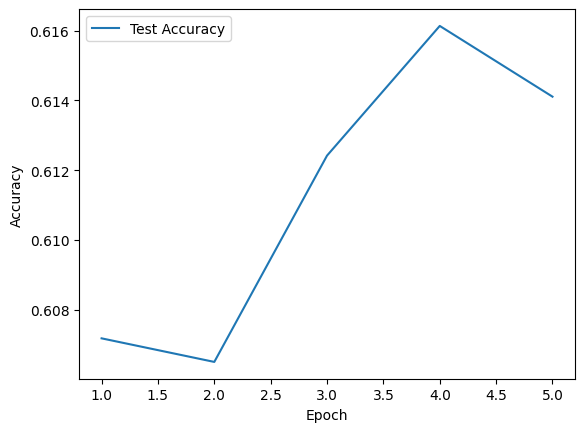

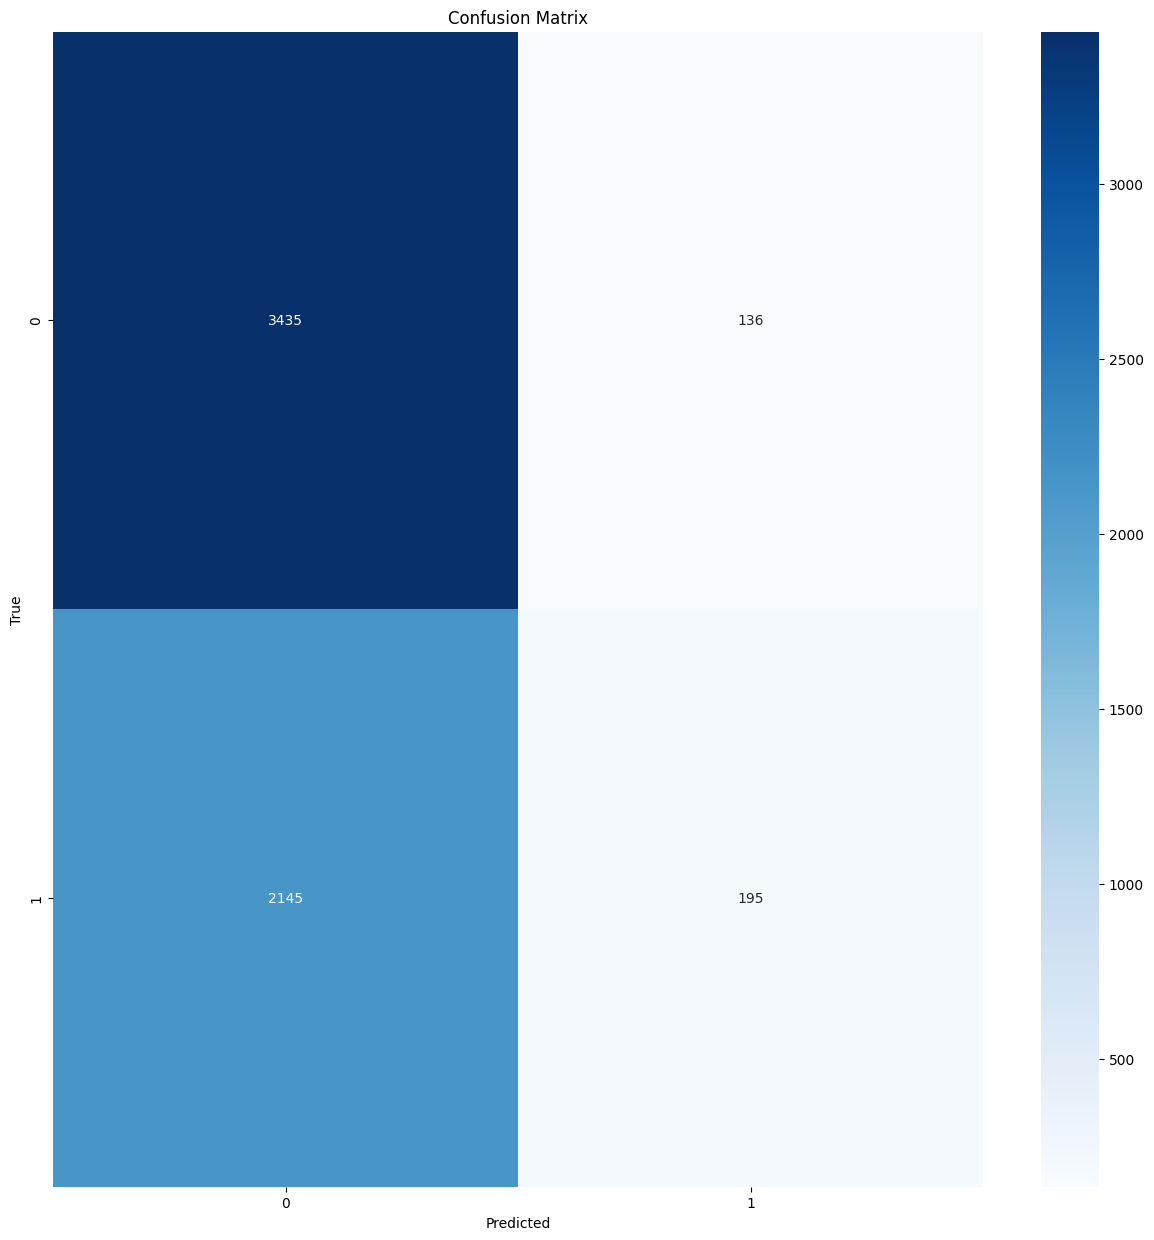

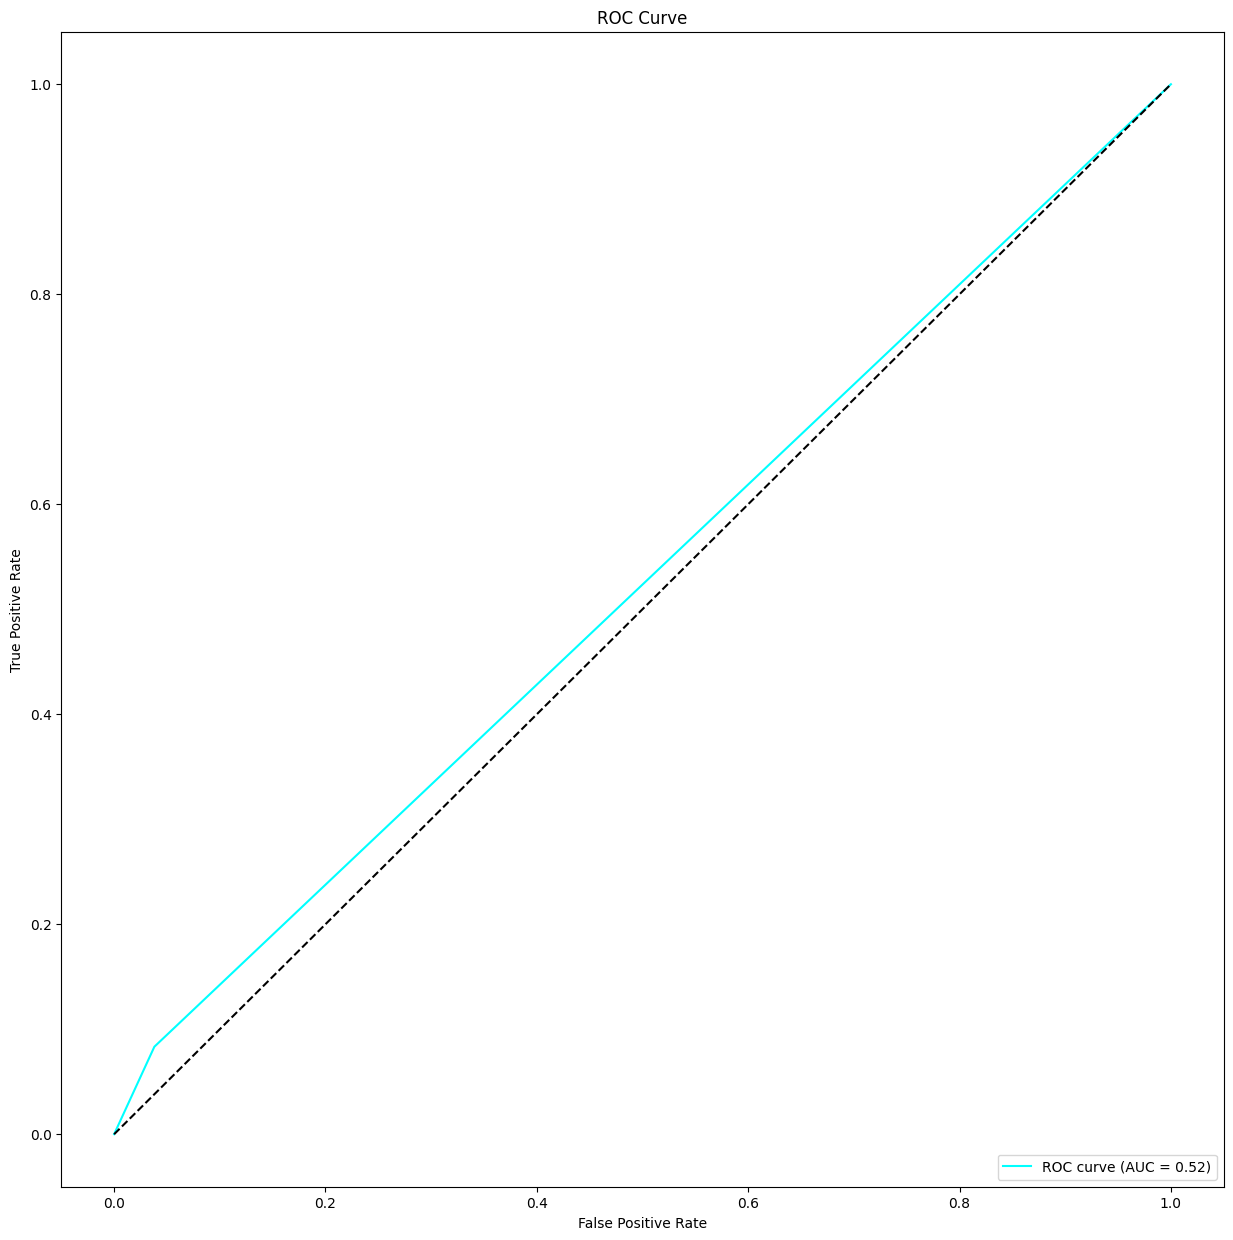

              precision    recall  f1-score   support

         0.0       0.62      0.96      0.75      3571
         1.0       0.59      0.08      0.15      2340

    accuracy                           0.61      5911
   macro avg       0.60      0.52      0.45      5911
weighted avg       0.61      0.61      0.51      5911



In [6]:
# Train early fusion model
print("Training Early Fusion Model:")
train_early_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=5, multilabel=multilabel, report=True, p=0.2)